# Phase 1: Data Cleaning and Preprocessing

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

#Loading the dataset
dataset_file_path = "C:\\Users\\TazeenQ\\team27_project\\data\\raw\\retail_sales_dataset.csv"
retail_data = pd.read_csv(dataset_file_path)

#Displaying the first couple of rows to check the data
retail_data.head(), retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


(   Transaction ID        Date Customer ID  Gender  Age Product Category  \
 0               1  2023-11-24     CUST001    Male   34           Beauty   
 1               2  2023-02-27     CUST002  Female   26         Clothing   
 2               3  2023-01-13     CUST003    Male   50      Electronics   
 3               4  2023-05-21     CUST004    Male   37         Clothing   
 4               5  2023-05-06     CUST005    Male   30           Beauty   
 
    Quantity  Price per Unit  Total Amount  
 0         3              50           150  
 1         2             500          1000  
 2         1              30            30  
 3         1             500           500  
 4         2              50           100  ,
 None)

In [20]:
#Renaming column names
retail_data.rename(columns = lambda x: x.strip().replace(" ", "_").lower(), inplace = True)

#Standardizing data types
#Converting date to datetime
retail_data['date'] = pd.to_datetime(retail_data['date'], errors = 'coerce')

#Handling missing values by replacing blanks with NaN and checking for missing values
retail_data.replace("", np.nan, inplace = True)
missing_summary = retail_data.isnull().sum()

#Dropping rows with date missing
retail_data.dropna(subset = ['date'], inplace = True)

#Filtering data, the dataset has values from 2023 and only 2 rows with data from 2024. I am removing those 2 rows.
retail_data = retail_data[retail_data['date'].dt.year != 2024].reset_index(drop = True)

#Dropping unwanted columns: transaction_id and customer_id
drop_these_columns = ['transaction_id', 'customer_id']
retail_data.drop(columns=drop_these_columns, inplace = True, errors = 'ignore')

#Summarizing dataset features
summary_stats = retail_data.describe(include = 'all')

#Choosing numerical columns to normalize
numerical_cols = ['age', 'quantity', 'price_per_unit', 'total_amount']

#Normalizng them
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(retail_data[numerical_cols])

#Creating a new DataFrame for the normalized data
normalized_dataset = retail_data.copy()
normalized_dataset[numerical_cols] = pd.DataFrame(normalized_data, columns = numerical_cols)

#Hot encoding my categorical variables
#categorical_columns = ['gender', 'product_category']
#normalized_dataset = pd.get_dummies(normalized_dataset, columns = categorical_columns, drop_first = False) #true for logistic regression (drop beauty category), false for KNN and random forests - multicollinearity

#Saving the normalized dataset to a new file
cleaned_dataset_file_path = "C:\\Users\\TazeenQ\\team27_project\\data\\processed\\processed_retail_sales_dataset.csv"
normalized_dataset.to_csv(cleaned_dataset_file_path, index = False) 

normalized_dataset.info(), normalized_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              998 non-null    datetime64[ns]
 1   gender            998 non-null    object        
 2   age               998 non-null    float64       
 3   product_category  998 non-null    object        
 4   quantity          998 non-null    float64       
 5   price_per_unit    998 non-null    float64       
 6   total_amount      998 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 54.7+ KB


(None,
         date  gender       age product_category  quantity  price_per_unit  \
 0 2023-11-24    Male  0.347826           Beauty  0.666667        0.052632   
 1 2023-02-27  Female  0.173913         Clothing  0.333333        1.000000   
 2 2023-01-13    Male  0.695652      Electronics  0.000000        0.010526   
 3 2023-05-21    Male  0.413043         Clothing  0.000000        1.000000   
 4 2023-05-06    Male  0.260870           Beauty  0.333333        0.052632   
 
    total_amount  
 0      0.063291  
 1      0.493671  
 2      0.002532  
 3      0.240506  
 4      0.037975  )

In [21]:
#Checking normalization for each numerical column
for col in numerical_cols:
    min_val = normalized_dataset[col].min()
    max_val = normalized_dataset[col].max()
    print(f"Column '{col}' - Min: {min_val}, Max: {max_val}")
    
#Checking if all values are between 0 and 1
if all((normalized_dataset[col].min() >= 0) & (normalized_dataset[col].max() <= 1) for col in numerical_cols):
    print("All numerical columns are properly normalized.")
else:
    print("Some columns are not properly normalized.")

Column 'age' - Min: 0.0, Max: 1.0
Column 'quantity' - Min: 0.0, Max: 1.0
Column 'price_per_unit' - Min: 0.0, Max: 1.0
Column 'total_amount' - Min: 0.0, Max: 1.0
All numerical columns are properly normalized.


# Phase 2: Initial Exploration with Visualizations

### Class Imbalance Analysis


A balanced dataset should have a similar number of high spenders and low spenders. If there is an imbalance in the dataset, I will need to adjust the classification model with methods like taking a subset of the data, oversampling, or SMOTE.<br><br>
As we can see for the plot below, this dataset is highly imbalanced because there are alot more low spenders than high spendes. This will likely contribute to poor model performance if I don't adjust the dataset.<br><br>
Upon consultation with Farzaneh, I will take a subset of the dataset with equal number of high and low spenders, with low spenders being chosen randomly.  

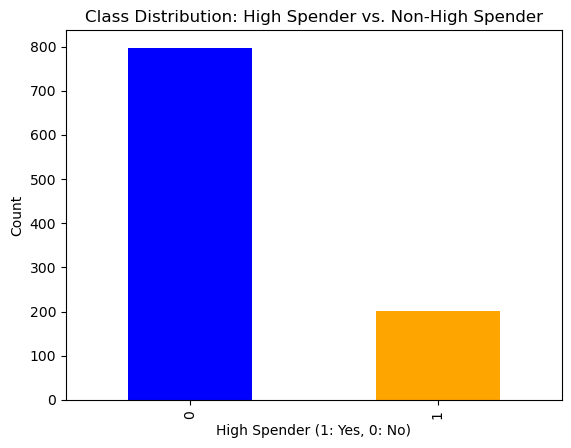

In [24]:
#Defining a threshold for high spender (top 25% of total_amount)
threshold = normalized_dataset['total_amount'].quantile(0.75)

#Creating a new column called high+spender
normalized_dataset['high_spender'] = normalized_dataset['total_amount'].apply(lambda x: 1 if x > threshold else 0)

#Ploting the distribution
normalized_dataset['high_spender'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution: High Spender vs. Non-High Spender")
plt.xlabel("High Spender (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()

### Categoric and Numeric Variable Analysis


In general, differences in median spending between categories and by gender means more variation within groups. This analysis is also going to show us spending patterns.<br><br>
As we can see in the plot below, customers consistently spend higher in Beauty and Electronics categories and lower spending in Clothing category.<br><br>
However, there is very little variation in spending by gender. This means that the spending patterns are pretty similar for both the genders.

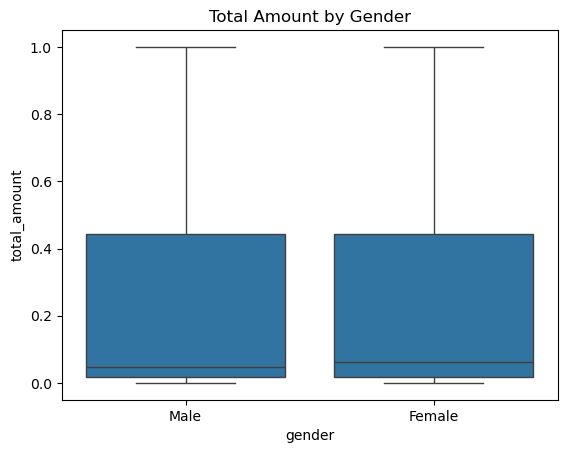

ValueError: Could not interpret value `product_category` for `x`. An entry with this name does not appear in `data`.

In [25]:
#Creating a box plot for gender
sns.boxplot(data=normalized_dataset, x='gender', y='total_amount')
plt.title("Total Amount by Gender")
plt.show()

#Creating a box plot for product category
sns.boxplot(data=normalized_dataset, x='product_category', y='total_amount')
plt.title("Total Amount by Product Category")
plt.show()

### Chi-Square Tests (Checking association between gender and product category)



A p-value of less than 0.05 indicates a significant relationship between two variables.<br><br>
As we can see in the output below, gender and product category do not have a significant relationship (p-value of 0.42). <br><br>
This means that certain product categories do not appeal to one gender more than the other. 

In [ ]:
#Creating a contingency table
contingency_table = pd.crosstab(normalized_dataset['gender'], normalized_dataset['product_category'])

#Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 Statistic: {chi2}, p-value: {p}")

#Printing results
if p < 0.05:
    print("Significant association between Gender and Product Category.")
else:
    print("No significant association between Gender and Product Category.")

Chi2 Statistic: 1.7536061144312953, p-value: 0.4161110708113299
No significant association between Gender and Product Category.


### Aggregate Analysis (Average Spending by Age and Gender)


As we can see in the plots below, gender does not seem to play a significant role in influencing spending behaviour. This feature is, therefore, not important for classification of high spenders.<br><br>
On the other hand, age may have a moderate impact on spending. We can see that 'Very Young' and 'Young' customers tends to spend more, on average, as compared to older customers. We can also see that spending decreases as age increase. 

Average Spending by Gender:
gender
Female    0.218506
Male      0.217296
Name: total_amount, dtype: float64

Average Spending by Age Group:
age_group
Very Young    0.242671
Young         0.231016
Middle-Age    0.208561
Old           0.208642
Very Old      0.199670
Name: total_amount, dtype: float64


C:\Users\TazeenQ\AppData\Local\Temp\ipykernel_25344\2798269250.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_avg = normalized_dataset.groupby('age_group')['total_amount'].mean()


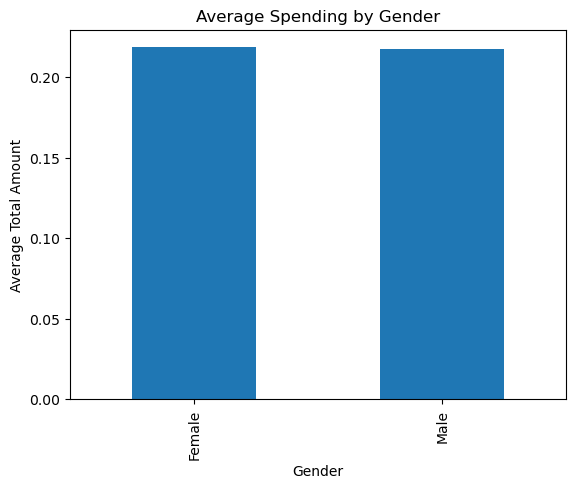

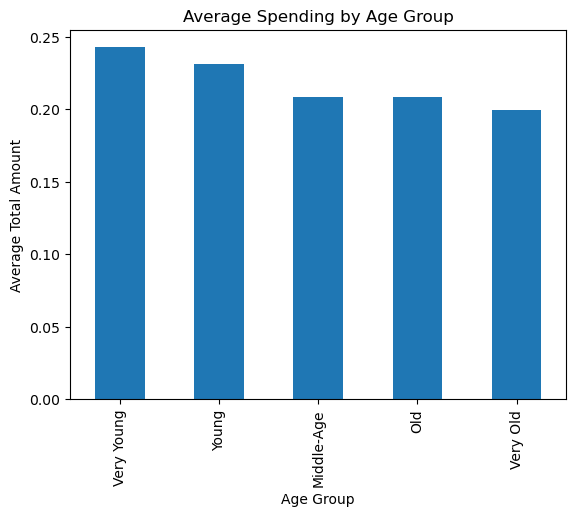

In [ ]:
#Defining age groups
normalized_dataset['age_group'] = pd.cut(normalized_dataset['age'], bins=5, labels=['Very Young', 'Young', 'Middle-Age', 'Old', 'Very Old'])

#Aggregate total_amount by gender
gender_avg = normalized_dataset.groupby('gender')['total_amount'].mean()
print("Average Spending by Gender:")
print(gender_avg)

#Aggregate total_amount by age group
age_group_avg = normalized_dataset.groupby('age_group')['total_amount'].mean()
print("\nAverage Spending by Age Group:")
print(age_group_avg)

#Creating a bar plot for gender averages
gender_avg.plot(kind='bar', title="Average Spending by Gender", ylabel="Average Total Amount", xlabel="Gender")
plt.show()

#Creating a bar plot for age group averages
age_group_avg.plot(kind='bar', title="Average Spending by Age Group", ylabel="Average Total Amount", xlabel="Age Group")
plt.show()

### Aggregate Analysis (Average Spending by Product Category and Age Group)

As we can see in the plot below, Very young and Young customers tend to spend more in each category. Again, spending decreases consistently as age increases, especially in Beauty category. Electronics spending shows higher average values overall, specially for very young and very old customers. <br><br>
Younger customers also spend more on Electronics and Beauty, while older customers show a balanced but lower spending pattern across all three categories.<br><br>
We can deduce from the plot that marketing efforts can target younger age groups for Electronics and Beauty products to maximize spending.

C:\Users\TazeenQ\AppData\Local\Temp\ipykernel_25344\1652255262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_age_group_avg = normalized_dataset.groupby(['product_category', 'age_group'])['total_amount'].mean().unstack()


<Figure size 1000x600 with 0 Axes>

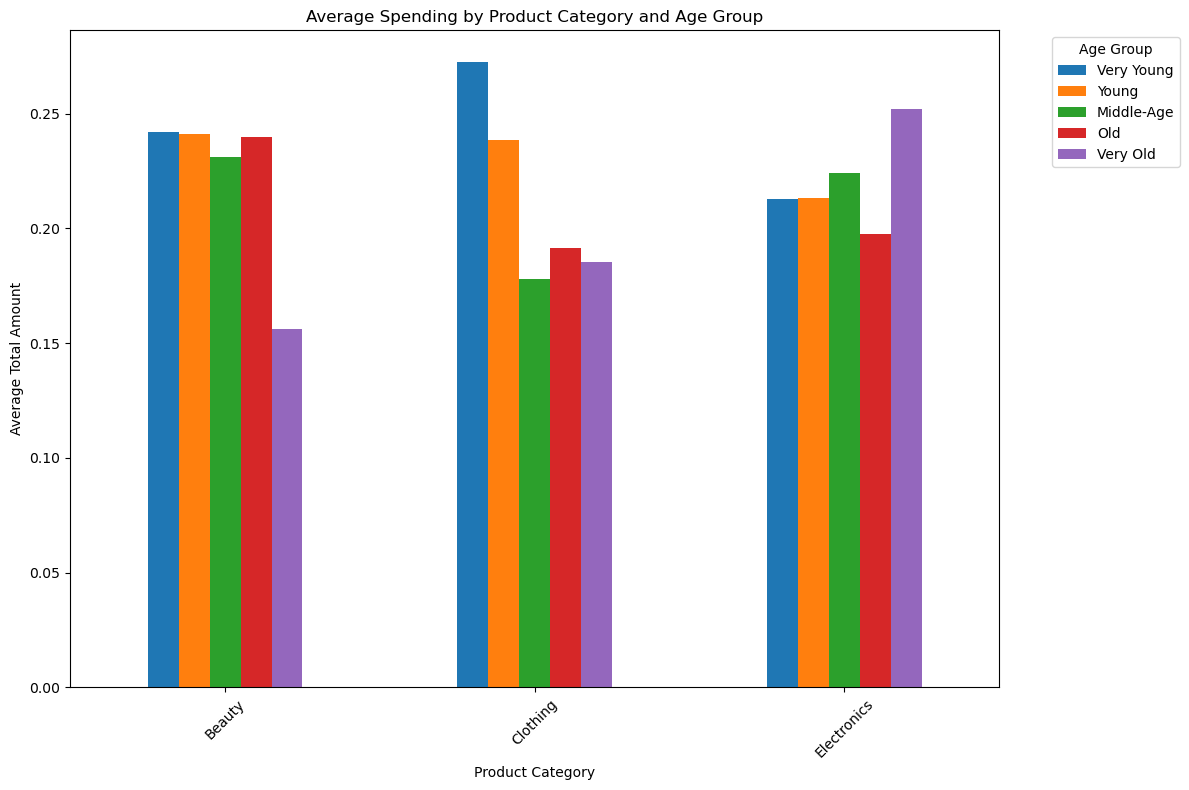

In [ ]:
#Aggregate total amount by product category and age group
category_age_group_avg = normalized_dataset.groupby(['product_category', 'age_group'])['total_amount'].mean().unstack()

#Creating a bar chart
plt.figure(figsize=(10, 6))
category_age_group_avg.plot(kind='bar', figsize=(12, 8))
plt.title("Average Spending by Product Category and Age Group")
plt.ylabel("Average Total Amount")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Correlation Analysis of Numerical Features

Positive values (close to 1) indicate a strong positive correlation between variables and negative values (close to -1) indicate a strong negative correlation.<br><br>
As we can see from the plot below, there is a strong positive correlation between price_per_unit and total_amount. This is natural, and self-explanatory.<br><br> 
There is a moderately positive correlation between quantity and total_amount. Again, higher quantity bough would mean a higher total_amount.<br><br>
There is weak or no correlation between other variables. This means that any of these variables is not a strong stand alone predictor for spending behaviour and customers are buying high quantities regardless of product's price per unit.<br><br>
This analysis was inconclusive, so I will rely on the other types of exploratory analyses above.

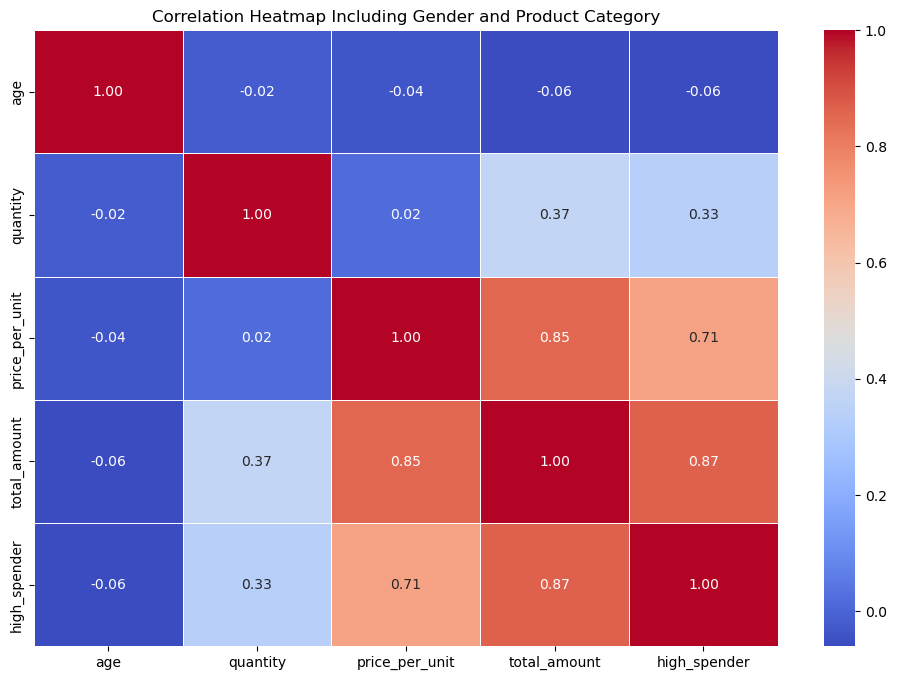

In [ ]:

#Selecting only numeric columns (not date)
numeric_columns = normalized_dataset.select_dtypes(include=['number'])

#Correlation matrix
correlation_matrix = numeric_columns.corr()

#Creating a correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap Including Gender and Product Category")
plt.show()



# Phase 3: Statistical Modelling (Classification)

## K-nearest Neighbor Model
### KNN Model: Age and Product Attributes


In [49]:

file_path = "C:\\Users\\TazeenQ\\team27_project\\data\\processed\\processed_retail_sales_dataset.csv"
processed_data = pd.read_csv(file_path)
# Prepare the dataset
# Load the high spender column based on the threshold logic
threshold = processed_data['total_amount'].quantile(0.75)
processed_data['high_spender'] = (processed_data['total_amount'] > threshold).astype(int)

# Encode categorical data for product_category
processed_data = pd.get_dummies(processed_data, columns=['product_category'], drop_first=True)

# Define features for the first model (age + product attributes)
features_age = ['age', 'quantity'] + [col for col in processed_data.columns if 'product_category_' in col]
X_age = processed_data[features_age]
y = processed_data['high_spender']

# Split the dataset into training and testing sets for the KNN model
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y, test_size=0.3, random_state=42)

# KNN model using age + product attributes
knn_age = KNeighborsClassifier(n_neighbors=5)
knn_age.fit(X_age_train, y_age_train)
y_age_pred = knn_age.predict(X_age_test)

# Results for KNN model with age + product attributes
accuracy_age = accuracy_score(y_age_test, y_age_pred)
report_age = classification_report(y_age_test, y_age_pred, output_dict=True)

accuracy_age, report_age


(0.7966666666666666,
 {'0': {'precision': 0.8345864661654135,
   'recall': 0.9288702928870293,
   'f1-score': 0.8792079207920792,
   'support': 239.0},
  '1': {'precision': 0.5,
   'recall': 0.2786885245901639,
   'f1-score': 0.35789473684210527,
   'support': 61.0},
  'accuracy': 0.7966666666666666,
  'macro avg': {'precision': 0.6672932330827068,
   'recall': 0.6037794087385966,
   'f1-score': 0.6185513288170923,
   'support': 300.0},
  'weighted avg': {'precision': 0.7665538847117794,
   'recall': 0.7966666666666666,
   'f1-score': 0.7732075733889179,
   'support': 300.0}})

Results:

    Accuracy: 79.6%
    Class 0 (Non-High Spenders):
        Precision: 83.4%
        Recall: 92.8%
        F1-Score: 87.9%
    Class 1 (High Spenders):
        Precision: 50%
        Recall: 27.8%
        F1-Score: 35.7%

Interpretation: The model performs well in predicting non-high spenders (Class 0), with high precision and recall. However, it struggles to classify high spenders (Class 1), with low recall and F1-score. This imbalance indicates difficulty in capturing the distinguishing features of high spenders based on age and product attributes.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on age and product attributes. While the model is accurate overall, its poor performance for high spenders makes it unreliable for practical use.

### KNN Model: Gender and Product Attributes

In [50]:
# Define features for the second model (gender + product attributes)
features_gender = ['quantity', 'gender'] + [col for col in processed_data.columns if 'product_category_' in col]

# Encode gender as binary (0 for Female, 1 for Male)
processed_data['gender'] = processed_data['gender'].map({'Female': 0, 'Male': 1})

X_gender = processed_data[features_gender]
y = processed_data['high_spender']

# Split the dataset into training and testing sets for the KNN model
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(X_gender, y, test_size=0.3, random_state=42)

# KNN model using gender + product attributes
knn_gender = KNeighborsClassifier(n_neighbors=5)
knn_gender.fit(X_gender_train, y_gender_train)
y_gender_pred = knn_gender.predict(X_gender_test)

# Results for KNN model with gender + product attributes
accuracy_gender = accuracy_score(y_gender_test, y_gender_pred)
report_gender = classification_report(y_gender_test, y_gender_pred, output_dict=True)

accuracy_gender, report_gender


(0.74,
 {'0': {'precision': 0.7970479704797048,
   'recall': 0.9037656903765691,
   'f1-score': 0.8470588235294118,
   'support': 239.0},
  '1': {'precision': 0.20689655172413793,
   'recall': 0.09836065573770492,
   'f1-score': 0.13333333333333333,
   'support': 61.0},
  'accuracy': 0.74,
  'macro avg': {'precision': 0.5019722611019214,
   'recall': 0.501063173057137,
   'f1-score': 0.49019607843137253,
   'support': 300.0},
  'weighted avg': {'precision': 0.6770505153327395,
   'recall': 0.74,
   'f1-score': 0.7019346405228758,
   'support': 300.0}})

Results:

    Accuracy: 74.0%
    Class 0 (Non-High Spenders):
        Precision: 79.7%
        Recall: 90.3%
        F1-Score: 84.7%
    Class 1 (High Spenders):
        Precision: 20.6%
        Recall: 9.8%
        F1-Score: 13.3%

Interpretation: The model predicts non-high spenders (Class 0) relatively well, but its performance for high spenders (Class 1) is poor, with extremely low precision, recall, and F1-score. This suggests the gender attribute, combined with product attributes, is insufficient to classify high spenders effectively.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on gender and product attributes. The model's overall performance is heavily skewed toward non-high spenders, making it unsuitable for practical use.

### Random Forest Model: Age and Product Attributes

Results:

    Accuracy: 74.3%
    Class 0 (Non-High Spenders):
        Precision: 81.3%
        Recall: 87.8%
        F1-Score: 84.5%
    Class 1 (High Spenders):
        Precision: 30.9%
        Recall: 21.3%
        F1-Score: 25.2%

Interpretation: The model demonstrates decent accuracy overall but performs poorly for high spenders (Class 1), with low precision, recall, and F1-score. This indicates that the features "age" and "quantity" are insufficient to classify high spenders effectively.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on age and quantity. The model struggles to differentiate high spenders from non-high spenders effectively.

In [51]:
# Random Forest model using age + product attributes
rf_age = RandomForestClassifier(random_state=42, n_estimators=100)
rf_age.fit(X_age_train, y_age_train)
y_age_rf_pred = rf_age.predict(X_age_test)

# Results for Random Forest model with age + product attributes
accuracy_age_rf = accuracy_score(y_age_test, y_age_rf_pred)
report_age_rf = classification_report(y_age_test, y_age_rf_pred, output_dict=True)

accuracy_age_rf, report_age_rf


(0.73,
 {'0': {'precision': 0.8264462809917356,
   'recall': 0.8368200836820083,
   'f1-score': 0.8316008316008316,
   'support': 239.0},
  '1': {'precision': 0.3275862068965517,
   'recall': 0.3114754098360656,
   'f1-score': 0.31932773109243695,
   'support': 61.0},
  'accuracy': 0.73,
  'macro avg': {'precision': 0.5770162439441436,
   'recall': 0.574147746759037,
   'f1-score': 0.5754642813466343,
   'support': 300.0},
  'weighted avg': {'precision': 0.7250113992590481,
   'recall': 0.73,
   'f1-score': 0.727438634497458,
   'support': 300.0}})

Results:

    Accuracy: 73.0%
    Class 0 (Non-High Spenders):
        Precision: 82.6%
        Recall: 83.7%
        F1-Score: 83.2%
    Class 1 (High Spenders):
        Precision: 32.8%
        Recall: 31.1%
        F1-Score: 31.9%

Interpretation: The Random Forest model shows slightly better performance for high spenders (Class 1) compared to KNN but still struggles to classify them accurately, with low precision, recall, and F1-score. The model's overall accuracy is primarily driven by its ability to predict non-high spenders (Class 0).

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on age and product attributes. Although Random Forest shows marginal improvement over KNN, it remains inadequate for distinguishing high spenders effectively.

### Random Forest Model: Gender and Product Attributes

In [33]:
# Random Forest model using gender + product attributes
rf_gender = RandomForestClassifier(random_state=42, n_estimators=100)
rf_gender.fit(X_gender_train, y_gender_train)
y_gender_rf_pred = rf_gender.predict(X_gender_test)

# Results for Random Forest model with gender + product attributes
accuracy_gender_rf = accuracy_score(y_gender_test, y_gender_rf_pred)
report_gender_rf = classification_report(y_gender_test, y_gender_rf_pred, output_dict=True)

accuracy_gender_rf, report_gender_rf


(0.78,
 {'0': {'precision': 0.8100358422939068,
   'recall': 0.9456066945606695,
   'f1-score': 0.8725868725868726,
   'support': 239.0},
  '1': {'precision': 0.38095238095238093,
   'recall': 0.13114754098360656,
   'f1-score': 0.1951219512195122,
   'support': 61.0},
  'accuracy': 0.78,
  'macro avg': {'precision': 0.5954941116231438,
   'recall': 0.538377117772138,
   'f1-score': 0.5338544119031924,
   'support': 300.0},
  'weighted avg': {'precision': 0.7227888718211299,
   'recall': 0.78,
   'f1-score': 0.7348356719088427,
   'support': 300.0}})

Results:

    Accuracy: 78.0%
    Class 0 (Non-High Spenders):
        Precision: 81.0%
        Recall: 94.6%
        F1-Score: 87.3%
    Class 1 (High Spenders):
        Precision: 38.1%
        Recall: 13.1%
        F1-Score: 19.5%

Interpretation: The Random Forest model performs reasonably well for non-high spenders (Class 0) but struggles significantly with high spenders (Class 1), as evidenced by its low precision, recall, and F1-score for Class 1. While overall accuracy is decent, the imbalance in performance across classes limits its usefulness.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on gender and product attributes. The model fails to capture the distinguishing characteristics of high spenders effectively, making it unsuitable for answering the research question.

### KNN Model: Age and Quantity

In [34]:
# Define features for KNN and Random Forest models based on age + quantity
features_age_quantity = ['age', 'quantity']
X_age_quantity = processed_data[features_age_quantity]
y = processed_data['high_spender']

# Split the dataset for KNN model using age + quantity
X_age_quantity_train, X_age_quantity_test, y_age_quantity_train, y_age_quantity_test = train_test_split(
    X_age_quantity, y, test_size=0.3, random_state=42
)

# KNN model using age + quantity
knn_age_quantity = KNeighborsClassifier(n_neighbors=5)
knn_age_quantity.fit(X_age_quantity_train, y_age_quantity_train)
y_age_quantity_pred = knn_age_quantity.predict(X_age_quantity_test)

# Results for KNN model with age + quantity
accuracy_age_quantity = accuracy_score(y_age_quantity_test, y_age_quantity_pred)
report_age_quantity = classification_report(y_age_quantity_test, y_age_quantity_pred, output_dict=True)

accuracy_age_quantity, report_age_quantity


(0.7433333333333333,
 {'0': {'precision': 0.813953488372093,
   'recall': 0.8786610878661087,
   'f1-score': 0.8450704225352113,
   'support': 239.0},
  '1': {'precision': 0.30952380952380953,
   'recall': 0.21311475409836064,
   'f1-score': 0.2524271844660194,
   'support': 61.0},
  'accuracy': 0.7433333333333333,
  'macro avg': {'precision': 0.5617386489479512,
   'recall': 0.5458879209822347,
   'f1-score': 0.5487488035006154,
   'support': 300.0},
  'weighted avg': {'precision': 0.7113861203396087,
   'recall': 0.7433333333333333,
   'f1-score': 0.7245662974611422,
   'support': 300.0}})

### KNN Model: Gender and Quantity

In [ ]:
# Define features for KNN model based on gender + quantity
features_gender_quantity = ['gender', 'quantity']
X_gender_quantity = processed_data[features_gender_quantity]

# Split the dataset for KNN model using gender + quantity
X_gender_quantity_train, X_gender_quantity_test, y_gender_quantity_train, y_gender_quantity_test = train_test_split(
    X_gender_quantity, y, test_size=0.3, random_state=42
)

# KNN model using gender + quantity
knn_gender_quantity = KNeighborsClassifier(n_neighbors=5)
knn_gender_quantity.fit(X_gender_quantity_train, y_gender_quantity_train)
y_gender_quantity_pred = knn_gender_quantity.predict(X_gender_quantity_test)

# Results for KNN model with gender + quantity
accuracy_gender_quantity = accuracy_score(y_gender_quantity_test, y_gender_quantity_pred)
report_gender_quantity = classification_report(y_gender_quantity_test, y_gender_quantity_pred, zero_division = 1,output_dict=True)

accuracy_gender_quantity, report_gender_quantity


(0.7966666666666666,
 {'0': {'precision': 0.7966666666666666,
   'recall': 1.0,
   'f1-score': 0.8868274582560297,
   'support': 239.0},
  '1': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 61.0},
  'accuracy': 0.7966666666666666,
  'macro avg': {'precision': 0.8983333333333333,
   'recall': 0.5,
   'f1-score': 0.44341372912801486,
   'support': 300.0},
  'weighted avg': {'precision': 0.8380111111111112,
   'recall': 0.7966666666666666,
   'f1-score': 0.7065058750773037,
   'support': 300.0}})

Results:

    Accuracy: 79.6%
    Class 0 (Non-High Spenders):
        Precision: 79.6%
        Recall: 100%
        F1-Score: 88.6%
    Class 1 (High Spenders):
        Precision: 100%
        Recall: 0%
        F1-Score: 0%

Interpretation: While the model performs well for non-high spenders (Class 0), it shows limited ability to classify high spenders (Class 1), with a low F1-score driven by poor recall and modest precision. This suggests "gender" and "quantity" alone do not provide sufficient information for effective classification.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on gender and quantity. The model's weak performance for high spenders limits its utility.

### Random Forest Model: Age and Quantity

In [36]:
# Random Forest model using age + quantity
rf_age_quantity = RandomForestClassifier(random_state=42, n_estimators=100)
rf_age_quantity.fit(X_age_quantity_train, y_age_quantity_train)
y_age_quantity_rf_pred = rf_age_quantity.predict(X_age_quantity_test)

# Results for Random Forest model with age + quantity
accuracy_age_quantity_rf = accuracy_score(y_age_quantity_test, y_age_quantity_rf_pred)
report_age_quantity_rf = classification_report(y_age_quantity_test, y_age_quantity_rf_pred, output_dict=True)

accuracy_age_quantity_rf, report_age_quantity_rf


(0.71,
 {'0': {'precision': 0.8140495867768595,
   'recall': 0.8242677824267782,
   'f1-score': 0.8191268191268192,
   'support': 239.0},
  '1': {'precision': 0.27586206896551724,
   'recall': 0.26229508196721313,
   'f1-score': 0.2689075630252101,
   'support': 61.0},
  'accuracy': 0.71,
  'macro avg': {'precision': 0.5449558278711883,
   'recall': 0.5432814321969957,
   'f1-score': 0.5440171910760147,
   'support': 300.0},
  'weighted avg': {'precision': 0.7046181248218866,
   'recall': 0.71,
   'f1-score': 0.707248903719492,
   'support': 300.0}})

Results:

    Accuracy: 71.0%
    Class 0 (Non-High Spenders):
        Precision: 81.4%
        Recall: 82.4%
        F1-Score: 81.9%
    Class 1 (High Spenders):
        Precision: 27.6%
        Recall: 26.2%
        F1-Score: 26.9%

Interpretation: The Random Forest model performs moderately for non-high spenders (Class 0) but poorly for high spenders (Class 1). The low precision, recall, and F1-score for high spenders suggest that the features "age" and "quantity" are not sufficient to classify high spenders effectively.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on age and quantity. The model's performance is inadequate for practical use in this context.

### Random Forest Model: Gender and Quantity

In [54]:
# Random Forest model using gender + quantity
rf_gender_quantity = RandomForestClassifier(random_state=42, n_estimators=100)
rf_gender_quantity.fit(X_gender_quantity_train, y_gender_quantity_train)
y_gender_quantity_rf_pred = rf_gender_quantity.predict(X_gender_quantity_test)

# Results for Random Forest model with gender + quantity
accuracy_gender_quantity_rf = accuracy_score(y_gender_quantity_test, y_gender_quantity_rf_pred)
report_gender_quantity_rf = classification_report(y_gender_quantity_test, y_gender_quantity_rf_pred, output_dict=True)

accuracy_gender_quantity_rf, report_gender_quantity_rf


c:\Users\TazeenQ\.conda\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TazeenQ\.conda\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TazeenQ\.conda\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

(0.7966666666666666,
 {'0': {'precision': 0.7966666666666666,
   'recall': 1.0,
   'f1-score': 0.8868274582560297,
   'support': 239.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 61.0},
  'accuracy': 0.7966666666666666,
  'macro avg': {'precision': 0.3983333333333333,
   'recall': 0.5,
   'f1-score': 0.44341372912801486,
   'support': 300.0},
  'weighted avg': {'precision': 0.6346777777777778,
   'recall': 0.7966666666666666,
   'f1-score': 0.7065058750773037,
   'support': 300.0}})

Results:

    Accuracy: 79.7%
    Class 0 (Non-High Spenders):
        Precision: 79.7%
        Recall: 100.0%
        F1-Score: 88.7%
    Class 1 (High Spenders):
        Precision: 0.0%
        Recall: 0.0%
        F1-Score: 0.0%

Interpretation: The model entirely fails to classify high spenders (Class 1), predicting all cases as non-high spenders (Class 0). While overall accuracy appears high, it is driven entirely by correct classification of non-high spenders, making the model completely unreliable for identifying high spenders.

Conclusion: No, we cannot reliably classify whether a customer is a high spender based on gender and quantity. The model's inability to predict high spenders renders it unsuitable for answering the research question.